# Convolutional Neural Network(CNN) 구현 & Time Series Data 학습

## 1. GPU 사용 여부 설정
GPU 사용 시 런타임 유형 GPU러 살장

- True : cupy 사용
- False : numpy 사용

In [1]:
# GPU 
GPU = False
if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
else:
    import numpy as np

# 2. Optimizer 및 FC, Loss layer 구현
- optimizer : Adam
- FC : Fully Connected Layer
- Loss : Mean Squared Error(MSE)

In [2]:
# Optimizer Adam
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [3]:
# Fully Connected Layer
class FullyConnected:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        self.x_shape = x.shape

        x = x.reshape(x.shape[0], -1)
        y = np.dot(x, W) + b        # y = X*W + b
        self.x = x

        return y

    def backward(self, dy):
        W, b = self.params
        x = self.x

        db = np.sum(dy, axis=0)
        dW = np.dot(x.T, dy)
        dx = np.dot(dy, W.T)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        dx = dx.reshape(*self.x_shape)

        return dx

# activation function (ReLU)
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x<=0)
        y = x.copy()
        y[self.mask] = 0

        return y
    
    def backward(self, dy):
        dy[self.mask] = 0
        dx = dy

        return dx
# MSE
def MSE(y, t):
    return 0.5*np.mean((y-t)**2)

# ReLU with MSE
class ReluWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.activation = ReLU()
        self.cache = None

    def forward(self, x, t):
        N, V = x.shape      # batch, ouput

        x = x.reshape(N, V)
        t = t.reshape(N, V)
        x = self.activation.forward(x)

        loss = MSE(x, t)
        self.cache = (t, x, (N, V))
        return loss

    def backward(self, dy = 1):
        t, x, (N, V) = self.cache
        dx = dy*(x-t) / N

        dx = self.activation.backward(dx)
        dx = dx.reshape(N, V)

        return dx

## 3. CNN Layer 구현
- im2col : image to column data
- col2im : column data to image



In [4]:
# CNN Layer (Conv, Pooling)
def im2col(data, filter_h, filter_w, stride = 1, padding = 0):
    # flatten data to 2D array
    N, C, H, W = data.shape
    
    out_h = (H + 2*padding - filter_h)//stride + 1
    out_w = (W + 2*padding - filter_w)//stride + 1

    # padding for H, W
    img = np.pad(data, 
                 [(0, 0), (0, 0), (padding, padding), (padding, padding)], 
                 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)

    return col

def col2im(col, shape, filter_h, filter_w, stride=1, padding=0):
    # 2D for img data
    # shape = original data shape
    N, C, H, W = shape
    out_h = (H + 2*padding - filter_h)//stride + 1
    out_w = (W + 2*padding - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H+2*padding + stride -1, W+2*padding+stride-1))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] =+ col[:, :, y, x, :, :]

    return img[:, :, padding:H+padding, padding:W+padding]


class Convolution:
    def __init__(self, W, b, stride=1, padding=0):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.stride = stride
        self.padding = padding
        self.cache = None

    def forward(self, x):
        weight, b = self.params
        FN, FC, FH, FW = weight.shape
        N, C, H, W = x.shape        # Samples, Channel, Time steps(24), Features

        out_h = (H + 2*self.padding - FH)//self.stride + 1
        out_w = (W + 2*self.padding - FW)//self.stride + 1

        col = im2col(x, FH, FW, self.stride, self.padding)
        col_W = weight.reshape(FN, -1).T

        y = np.dot(col, col_W) + b
        y = y.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.cache = (x, col, col_W)

        return y

    def backward(self, dy):
        W, b = self.params
        x, col, col_W = self.cache
        FN, C, FH, FW = W.shape
        
        dy = dy.transpose(0, 2, 3, 1).reshape(-1, FN)

        db = np.sum(dy, axis=0)
        dW = np.dot(col.T, dy)
        dW = dW.transpose(1, 0).reshape(FN, C, FH, FW)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        dx = np.dot(dy, col_W.T)
        dx = col2im(dx, x.shape, FH, FW, self.stride, self.padding)

        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, padding=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.padding)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        y = np.max(col, axis=1)
        y = y.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.cache = (x, arg_max)

        return y

    def backward(self, dy):
        x, arg_max = self.cache

        dy = dy.transpose(0, 2, 3, 1)      # N, C, H, W
        pool_size = self.pool_h*self.pool_w

        dmax = np.zeros((dy.size, pool_size))
        dmax[np.arange(arg_max.size), arg_max.flatten()] = dy.flatten()
        dmax = dmax.reshape(dy.shape + (pool_size, ))
        dcol = dmax.reshape(dmax.shape[0]*dmax.shape[1]*dmax.shape[2], -1)
        dx = col2im(dcol, x.shape, 
                    self.pool_h, 
                    self.pool_w, 
                    self.stride, 
                    self.padding)
        
        return dx

## 4. Model 설계
### Model Architecture
- conv -> relu -> pool -> fc -> relu -> fc -> relu

In [5]:
# CNN Model
class Model:
    def __init__(self, input_dim = (1, 24, 8), 
                 params={'filter_num':30, 'filter_size':5, 
                         'padding':0, 'stride':1},
                 hidden_size=100, output_size=1):
        filter_num = params['filter_num']
        filter_size = params['filter_size']
        padding = params['padding']
        stride = params['stride']

        # not square
        input_size = input_dim[1]
        input_size2 = input_dim[2]
        conv_output_size_h = (input_size - filter_size + 2*padding)/stride + 1
        conv_output_size_w = (input_size2 - filter_size + 2*padding)/stride + 1
        pool_output_size = int(filter_num*(conv_output_size_h/2)*(conv_output_size_w/2))

        self.params = {}
        rand = np.random.randn

        # He initialize
        self.params['cnn_W'] = rand(filter_num, input_dim[0], filter_size, filter_size) / np.sqrt(filter_num/2)
        self.params['cnn_b'] = np.zeros(filter_num)
        self.params['W1'] = rand(pool_output_size, hidden_size)/np.sqrt(pool_output_size/2)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = rand(hidden_size, output_size)/np.sqrt(hidden_size/2)
        self.params['b2'] = np.zeros(output_size)

        self.layers=[
                     Convolution(self.params['cnn_W'], self.params['cnn_b'], stride, padding),
                     ReLU(),
                     Pooling(pool_h=2, pool_w=2, stride=2),
                     FullyConnected(self.params['W1'], self.params['b1']),
                     ReLU(),
                     FullyConnected(self.params['W2'], self.params['b2']),
        ]
        self.loss_layer = ReluWithLoss()

        self.grads = []
        self.params = []
        for i in [0, 3, 5]:
            self.params += self.layers[i].params
            self.grads+=self.layers[i].grads


    def predict(self, x):
        x = np.array(x)
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        x = np.array(x)
        t = np.array(t)
        x = self.predict(x)
        loss = self.loss_layer.forward(x, t)
        return loss

    def backward(self, dy=1):
        dy = self.loss_layer.backward(dy)

        for layer in reversed(self.layers):
            dy = layer.backward(dy)
        return dy

    def fit(self, train_X=None, train_y=None, epochs=1, batch_size=1, verbose=0):
        
        optimizer = Adam(0.01)

        data_size = train_X.shape[0]
        max_iters = data_size // batch_size

        for epoch in range(1, epochs+1):
            # shuffle
            idx = np.random.permutation(np.arange(data_size))
            x_data = train_X[idx]
            y_data = train_y[idx]

            epoch_loss = 0
            start_time = time.time()

            for iter in range(max_iters):
                batch_x = x_data[iter*batch_size:(iter+1)*batch_size]
                batch_y = y_data[iter*batch_size:(iter+1)*batch_size]

                loss = self.forward(batch_x, batch_y)
                self.backward()
                params, grads = self.params, self.grads
                optimizer.update(params, grads)

                epoch_loss += loss.item()
            avg_loss = epoch_loss / max_iters

            if verbose:
                duration = time.time()-start_time
                print(f'epoch:{epoch}/{epochs}, 시간:{duration:.2f}[s], loss:{avg_loss:.5f}')
            




## 5. Data Prepare
- beijing air pollution data (time series data)
- remove first 24hours (Nan values)

In [6]:
# data prepare
import pandas as pd
from datetime import datetime

df_parser = lambda x: datetime.strptime(x, '%Y %m %d %H')    # string to datetime
# data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
df = pd.read_csv(data_url, sep=',', parse_dates=[['year', 'month', 'day', 'hour']], date_parser=df_parser, index_col=0)

del df['No']
df.columns = ['pm2.5', 'dewp', 'temp', 'pres', 'cbwd','wind_speed', 'snow', 'rain']
df = df[24:]            # NaN values in first 24hours
df.head()

,pm2.5,dewp,temp,pres,cbwd,wind_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## 6. Data Preprocessing
- LabelEncoder : wind diredction
- MinMaxScaling : standardization 0 ~ 1 [min:0, max:1]
- train-test split : train(365 days), test(remains)

    time step = 24  
    features = 8  
      
    **train X shape : (365 * 24, 1, 24, 8)** => 365 days  
    **test X shape : (28836, 1, 24, 8)**  => about 1200 days


In [7]:
def series_to_img(dataset, time_step=1):
    num = dataset.shape[1]      # features num
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    # sequence t-n to t-1
    for i in range(time_step, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num)]

    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy

dataset = df.values
encoder = LabelEncoder()
dataset[:, 4] = encoder.fit_transform(dataset[:,4])
dataset = dataset.astype('f')

last_hours = 24
features = 8
del_idx = last_hours*features + 1
del_cols = [i for i in range(del_idx, del_idx+features-1)]
reframed = series_to_img(dataset, last_hours)
reframed.drop(reframed.columns[del_cols], axis=1, inplace=True)

dataset = reframed.values
train_hours = 365 * 24
train = dataset[:train_hours, :]
test = dataset[train_hours:, :]
# split
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# scaling
scaler_x = MinMaxScaler()
scaled_x = scaler_x.fit_transform(train_X)

test_X = scaler_x.transform(test_X)

# reshape
train_X = scaled_x.reshape(scaled_x.shape[0], last_hours, features)
test_X = test_X.reshape(test_X.shape[0], last_hours, features)

train_X = train_X.reshape(-1, 1, last_hours, features)
test_X = test_X.reshape(-1, 1, last_hours, features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 24, 8) (8760,) (28836, 1, 24, 8) (28836,)


## 7. Training Model
### hyper parameter
- epoch : 100
- batch size : 64
- learning rate : 0.1

In [ ]:
# training
import time

batch_size = 64
hidden_size = 100
time_size = 24
feature_size = 8

learning_rate = 0.01
epochs = 100

model = Model(input_dim=(1, time_size, feature_size), hidden_size=hidden_size, output_size=1)
optimizer = Adam(learning_rate)
loss_arr = []

data_size = train_X.shape[0]
max_iters = data_size//batch_size

for epoch in range(epochs):
    idx = numpy.random.permutation(numpy.arange(data_size))
    train_X = train_X[idx]
    train_y = train_y[idx]

    epoch_loss = 0
    start_time = time.time()
    
    for iters in range(max_iters):
        batch_x = train_X[iters*batch_size:(iters+1)*batch_size]
        batch_y = train_y[iters*batch_size:(iters+1)*batch_size]

        loss = model.forward(batch_x, batch_y)
        model.backward()
        params, grads = model.params, model.grads
        optimizer.update(params, grads)

        epoch_loss += loss.item()
    avg_loss = epoch_loss/max_iters

    if epoch%10 == 0:
        duration = time.time()- start_time
        print(f'epoch:{epoch}/{epochs}, 시간:{duration:.2f}[s], loss:{avg_loss:.5f}')
    loss_arr.append(avg_loss)


epoch:0/100, 시간:2.73[s], loss:3167.74079
epoch:10/100, 시간:2.63[s], loss:493.38700
epoch:20/100, 시간:2.67[s], loss:418.36861
epoch:30/100, 시간:2.68[s], loss:334.41811
epoch:40/100, 시간:2.69[s], loss:298.63077
epoch:50/100, 시간:3.20[s], loss:257.07470
epoch:60/100, 시간:3.03[s], loss:213.84620
epoch:70/100, 시간:2.98[s], loss:203.56646
epoch:80/100, 시간:2.98[s], loss:177.55769
epoch:90/100, 시간:3.02[s], loss:165.34731


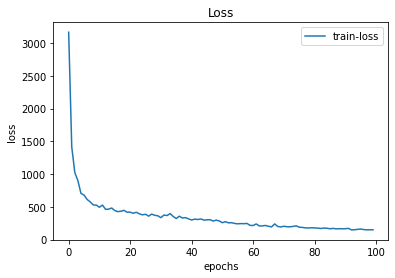

In [ ]:
# visualize training loss
import matplotlib.pyplot as plt

# loss graph
plt.plot(range(epochs), loss_arr, label='train-loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

## 8. Evaluation Model
- test data : not using in training
- metrics : Mean Squared Error(MSE), Root MSE(RMSE)

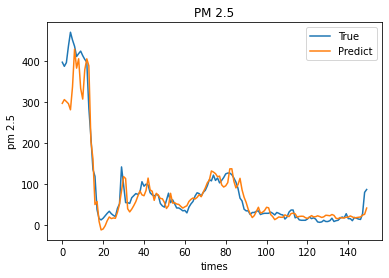

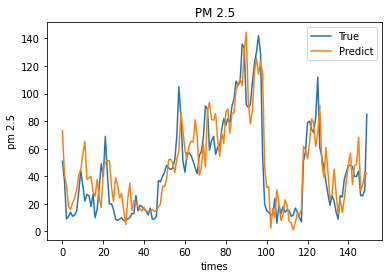

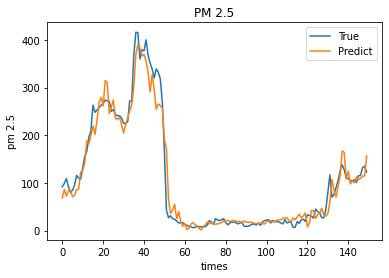

In [ ]:
# evaluate model with test data
import numpy

true = test_y.reshape(-1, 1)
predict = model.predict(test_X)

def graph(x_range, iters):
    for i in range(iters):
        plt.title('PM 2.5')
        plt.plot(range(x_range), true[i*x_range:(i+1)*x_range], label='True')
        plt.plot(range(x_range), predict[i*x_range:(i+1)*x_range], label='Predict')
        plt.xlabel('times')
        plt.ylabel('pm 2.5')
        plt.legend(loc='upper right')
        plt.show()

graph(150, 3)

In [ ]:
# mse, rmse, mae
def MAE_metric(x, t):
    return np.mean(np.abs(x-t))

def MSE_metric(x, t):
    return np.mean((x-t)**2)
print('*evaluate*')
print('mse : ', MSE_metric(predict, true))
print('rmse : ', np.sqrt(MSE_metric(predict, true)))
print('mae : ', MAE_metric(predict, true))

*evaluate*
mse :  865.0665158487705
rmse :  29.412013121321202
mae :  18.797161628287935


In [10]:
# lr, filter size, fileter num, 
def fit_model(train_x,train_y, config):
    '''
    train : train data
    config : parameters
    '''
    # unpack config
    filter_num, filter_size, n_epochs, n_batch = config

    params = {'filter_num':filter_num, 'filter_size':filter_size, 'padding':0, 'stride':1}
    model = Model(params=params)
    #self, train_X=None, train_y=None, epochs=1, batch_size=1, verbose=0
    model.fit(train_X=train_x, train_y=train_y, epochs=n_epochs, batch_size=n_batch, verbose=1)
    return model


In [12]:
import time

config = 30, 5, 10, 64
fit_model(train_X, train_y, config)

epoch:1/10, 시간:2.94[s], loss:3507.75431
epoch:2/10, 시간:2.81[s], loss:1703.41886
epoch:3/10, 시간:2.91[s], loss:1119.54094
epoch:4/10, 시간:2.90[s], loss:909.20655
epoch:5/10, 시간:2.90[s], loss:717.21318
epoch:6/10, 시간:2.82[s], loss:669.93023
epoch:7/10, 시간:2.80[s], loss:612.59733
epoch:8/10, 시간:2.89[s], loss:567.72450
epoch:9/10, 시간:2.81[s], loss:561.86549
epoch:10/10, 시간:2.84[s], loss:523.02528
